<a href="https://colab.research.google.com/github/adenurchalisa/Automatic-Photo-Clustering-System-Optimization-HDBSCAN/blob/main/notebooks/6_Distance_Metric_Compare.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
print("🔍 Checking CUDA version...")
!nvcc --version | grep "release"

print("\n⏳ Installing RAPIDS cuML...")
!pip install --extra-index-url=https://pypi.nvidia.com cudf-cu12 cuml-cu12 -q

print("\n⏳ Installing HDBSCAN (CPU version untuk precomputed matrix)...")
!pip install hdbscan -q

print("\n" + "="*60)
print("✅ VERIFYING INSTALLATIONS")
print("="*60)

# CuPy verification
try:
    import cupy as cp
    print(f"   CuPy: {cp.__version__} ✅")

    # GPU info
    n_devices = cp.cuda.runtime.getDeviceCount()
    print(f"   GPU: {n_devices} device(s) detected")

    device_id = cp.cuda.runtime.getDevice()
    device_props = cp.cuda.runtime.getDeviceProperties(device_id)
    gpu_name = device_props['name'].decode('utf-8') if isinstance(device_props['name'], bytes) else device_props['name']
    print(f"   GPU Name: {gpu_name}")

    # Quick test
    test = cp.array([1, 2, 3])
    print(f"   GPU Test: {cp.asnumpy(test)} ✅")

    # Memory info
    mem_info = cp.cuda.Device(0).mem_info
    print(f"   Free Memory: {mem_info[0] / 1024**3:.2f} GB / {mem_info[1] / 1024**3:.2f} GB")

except Exception as e:
    print(f"   CuPy Error: {e}")

# HDBSCAN verification
try:
    import hdbscan
    # Try different ways to get version
    try:
        version = hdbscan.__version__
    except AttributeError:
        try:
            from importlib.metadata import version as get_version
            version = get_version('hdbscan')
        except:
            version = "installed (version unknown)"
    print(f"   HDBSCAN: {version} ✅")
except ImportError as e:
    print(f"   HDBSCAN: ❌ {e}")

print("\n" + "="*60)
print("✅ Installation complete!")
print("="*60)

🔍 Checking CUDA version...
Cuda compilation tools, release 12.8, V12.8.93

⏳ Installing RAPIDS cuML...

⏳ Installing HDBSCAN (CPU version untuk precomputed matrix)...

✅ VERIFYING INSTALLATIONS
   CuPy: 14.0.1 ✅
   GPU: 1 device(s) detected
   GPU Name: Tesla T4
   GPU Test: [1 2 3] ✅
   Free Memory: 14.46 GB / 14.56 GB
   HDBSCAN: 0.8.41 ✅

✅ Installation complete!


In [ ]:
import numpy as np
import cupy as cp
import pickle
import time
import os
import warnings
from collections import Counter
from datetime import datetime

warnings.filterwarnings('ignore')

import hdbscan
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-whitegrid')

class Config:
    """Central configuration for Experiment 1."""

    # Paths
    EMBEDDINGS_PATH = '/content/drive/MyDrive/OTW S.KOM/Embeddings/embeddings_data.pkl'
    RESULTS_DIR = '/content/drive/MyDrive/OTW S.KOM/Results/'
    PLOTS_DIR = '/content/drive/MyDrive/OTW S.KOM/Results/Plots/'

    # Best parameters from hyperparameter tuning
    BEST_PARAMS = {
        'min_cluster_size': 20,
        'min_samples': 50,
        'cluster_selection_method': 'eom'
    }

    # Euclidean baseline (dari notebook Hyperparameter Tuning)
    EUCLIDEAN_BASELINE = {
        'silhouette': 0.3119,
        'dbi': 1.2217,
        'n_clusters': 44,
        'noise_ratio': 0.693,
        'n_noise': 8808
    }

# Get HDBSCAN version safely
def get_hdbscan_version():
    try:
        return hdbscan.__version__
    except AttributeError:
        try:
            from importlib.metadata import version
            return version('hdbscan')
        except:
            return "installed"

print("="*60)
print("📦 LIBRARIES IMPORTED")
print("="*60)
print(f"   NumPy  : {np.__version__}")
print(f"   CuPy   : {cp.__version__}")
print(f"   HDBSCAN: {get_hdbscan_version()}")

# GPU Info
print(f"\n🖥️ GPU INFO:")
device = cp.cuda.Device(0)
mem_info = device.mem_info
print(f"   Free Memory: {mem_info[0] / 1024**3:.2f} GB")
print(f"   Total Memory: {mem_info[1] / 1024**3:.2f} GB")

print("\n" + "="*60)
print("⚙️ CONFIGURATION")
print("="*60)
print(f"   Parameters: mcs={Config.BEST_PARAMS['min_cluster_size']}, ms={Config.BEST_PARAMS['min_samples']}")
print(f"\n   📊 EUCLIDEAN BASELINE:")
print(f"   • Silhouette: {Config.EUCLIDEAN_BASELINE['silhouette']}")
print(f"   • DBI: {Config.EUCLIDEAN_BASELINE['dbi']}")
print(f"   • Clusters: {Config.EUCLIDEAN_BASELINE['n_clusters']}")
print(f"   • Noise: {Config.EUCLIDEAN_BASELINE['noise_ratio']:.1%}")

print("\n" + "="*60)

📦 LIBRARIES IMPORTED
   NumPy  : 2.0.2
   CuPy   : 14.0.1
   HDBSCAN: 0.8.41

🖥️ GPU INFO:
   Free Memory: 14.46 GB
   Total Memory: 14.56 GB

⚙️ CONFIGURATION
   Parameters: mcs=20, ms=50

   📊 EUCLIDEAN BASELINE:
   • Silhouette: 0.3119
   • DBI: 1.2217
   • Clusters: 44
   • Noise: 69.3%



In [ ]:
from google.colab import drive

print("="*60)
print("📁 MOUNT DRIVE & LOAD DATA")
print("="*60)

if os.path.exists('/content/drive/MyDrive'):
    print("\n✅ Google Drive sudah ter-mount!")
else:
    drive.mount('/content/drive')

os.makedirs(Config.RESULTS_DIR, exist_ok=True)
os.makedirs(Config.PLOTS_DIR, exist_ok=True)

print(f"\n⏳ Loading embeddings...")
with open(Config.EMBEDDINGS_PATH, 'rb') as f:
    data = pickle.load(f)

embeddings = np.array(data['embeddings']).astype('float64')
metadata = data['metadata']

print(f"\n✅ Data loaded!")
print(f"   Shape: {embeddings.shape}")
print(f"   Dtype: {embeddings.dtype}")

# Estimate GPU memory needed for distance matrix
n_samples = embeddings.shape[0]
matrix_size_gb = (n_samples * n_samples * 8) / (1024**3)  # float64
print(f"\n📊 Distance Matrix Info:")
print(f"   Size: {n_samples} × {n_samples}")
print(f"   Memory needed: ~{matrix_size_gb:.2f} GB")

print("\n" + "="*60)

📁 MOUNT DRIVE & LOAD DATA
Mounted at /content/drive

⏳ Loading embeddings...

✅ Data loaded!
   Shape: (12715, 512)
   Dtype: float64

📊 Distance Matrix Info:
   Size: 12715 × 12715
   Memory needed: ~1.20 GB



In [ ]:
def compute_qjsd_distance_matrix_gpu(embeddings, verbose=True):
    """
    Menghitung QJSD distance matrix dengan GPU (CuPy).
    FULLY VECTORIZED - Tidak ada for-loop!

    Parameters
    ----------
    embeddings : numpy.ndarray
        Matrix of embeddings (n_samples, n_features)
    verbose : bool
        Print progress

    Returns
    -------
    distance_matrix : numpy.ndarray
        Symmetric QJSD distance matrix (n_samples, n_samples) - di CPU
    """
    if verbose:
        print(f"\n⏳ Computing QJSD distance matrix (GPU/CuPy)...")
        print(f"   Samples: {embeddings.shape[0]:,}")
        print(f"   Features: {embeddings.shape[1]}")
        print(f"   Method: Fully vectorized GPU computation")

    start_time = time.time()

    # =========================================================================
    # STEP 0: Transfer data ke GPU
    # =========================================================================
    transfer_start = time.time()
    embeddings_gpu = cp.asarray(embeddings)
    transfer_time = time.time() - transfer_start
    if verbose:
        print(f"\n   [1/6] Data transferred to GPU ({transfer_time:.2f}s)")

    # =========================================================================
    # STEP 1: Normalisasi semua embeddings (GPU)
    # =========================================================================
    step_start = time.time()
    norms = cp.linalg.norm(embeddings_gpu, axis=1, keepdims=True)
    norms = cp.where(norms < 1e-10, 1.0, norms)
    v_normalized = embeddings_gpu / norms
    if verbose:
        print(f"   [2/6] Normalization complete ({time.time() - step_start:.2f}s)")

    # =========================================================================
    # STEP 2: Hitung Inner Product Matrix untuk SEMUA pasangan (GPU - FAST!)
    # Ini adalah operasi paling intensif - GPU sangat cepat untuk ini
    # =========================================================================
    step_start = time.time()
    inner_product_matrix = cp.dot(v_normalized, v_normalized.T)
    cp.clip(inner_product_matrix, -1.0, 1.0, out=inner_product_matrix)
    if verbose:
        print(f"   [3/6] Inner product matrix computed ({time.time() - step_start:.2f}s)")

    # =========================================================================
    # STEP 3: Hitung eigenvalues dari mixed states (GPU)
    # λ± = (1 ± |⟨v₁|v₂⟩|) / 2
    # =========================================================================
    step_start = time.time()
    overlap = cp.abs(inner_product_matrix)
    l_plus = (1.0 + overlap) / 2.0
    l_minus = (1.0 - overlap) / 2.0
    if verbose:
        print(f"   [4/6] Eigenvalues computed ({time.time() - step_start:.2f}s)")

    # =========================================================================
    # STEP 4: Hitung Von Neumann Entropy Matrix (GPU)
    # S = -λ₊ log₂(λ₊) - λ₋ log₂(λ₋)
    # =========================================================================
    step_start = time.time()
    ent_plus = -l_plus * cp.log2(l_plus + 1e-10)
    ent_minus = -l_minus * cp.log2(l_minus + 1e-10)
    if verbose:
        print(f"   [5/6] Entropy computed ({time.time() - step_start:.2f}s)")

    # =========================================================================
    # STEP 5: QJSD Matrix & Distance extraction (GPU)
    # =========================================================================
    step_start = time.time()
    qjsd_matrix = ent_plus + ent_minus

    # Diagonal harus 0 (jarak ke diri sendiri)
    cp.fill_diagonal(qjsd_matrix, 0.0)

    # sqrt(QJSD) adalah proper metric
    distance_matrix_gpu = cp.sqrt(cp.maximum(0, qjsd_matrix))
    if verbose:
        print(f"   [6/6] Distance matrix computed ({time.time() - step_start:.2f}s)")

    # =========================================================================
    # STEP 6: Transfer kembali ke CPU (untuk HDBSCAN)
    # =========================================================================
    transfer_start = time.time()
    distance_matrix = cp.asnumpy(distance_matrix_gpu)
    transfer_time = time.time() - transfer_start

    # Free GPU memory
    del embeddings_gpu, v_normalized, inner_product_matrix
    del overlap, l_plus, l_minus, ent_plus, ent_minus
    del qjsd_matrix, distance_matrix_gpu
    cp.get_default_memory_pool().free_all_blocks()

    elapsed = time.time() - start_time

    if verbose:
        print(f"\n✅ Distance matrix computed!")
        print(f"   Shape: {distance_matrix.shape}")
        print(f"   Total time: {elapsed:.2f}s ⚡ (GPU accelerated)")
        print(f"   Transfer back to CPU: {transfer_time:.2f}s")
        print(f"   Distance range: [{distance_matrix[distance_matrix > 0].min():.4f}, {distance_matrix.max():.4f}]")

        # Memory info
        mem_mb = distance_matrix.nbytes / 1024 / 1024
        print(f"   Matrix memory: {mem_mb:.1f} MB")

    return distance_matrix


# =============================================================================
# VERIFICATION TESTS
# =============================================================================
print("="*60)
print("✅ QJSD FUNCTION DEFINED (GPU/CuPy)")
print("="*60)

print("\n🧪 VERIFICATION TESTS:")

# Test dengan small sample
test_emb = np.random.randn(100, 512).astype('float64')
test_matrix = compute_qjsd_distance_matrix_gpu(test_emb, verbose=False)

print(f"   • Matrix shape: {test_matrix.shape} ✅")
print(f"   • Symmetric: {np.allclose(test_matrix, test_matrix.T)} ✅")
print(f"   • Diagonal zeros: {np.allclose(np.diag(test_matrix), 0)} ✅")
print(f"   • Non-negative: {(test_matrix >= 0).all()} ✅")

# Test specific cases
v1 = np.random.randn(1, 512)

# Identical vectors (distance should be 0)
test_identical = np.vstack([v1, v1])
d_same = compute_qjsd_distance_matrix_gpu(test_identical, verbose=False)[0, 1]
print(f"   • Identical vectors: {d_same:.6f} (expected: 0) ✅")

# Opposite vectors (same quantum state, distance should be 0)
test_opposite = np.vstack([v1, -v1])
d_opp = compute_qjsd_distance_matrix_gpu(test_opposite, verbose=False)[0, 1]
print(f"   • Opposite vectors: {d_opp:.6f} (expected: 0) ✅")

# Clear GPU memory
cp.get_default_memory_pool().free_all_blocks()

print("\n" + "="*60)

✅ QJSD FUNCTION DEFINED (GPU/CuPy)

🧪 VERIFICATION TESTS:
   • Matrix shape: (100, 100) ✅
   • Symmetric: True ✅
   • Diagonal zeros: True ✅
   • Non-negative: True ✅
   • Identical vectors: 0.000000 (expected: 0) ✅
   • Opposite vectors: 0.000000 (expected: 0) ✅



In [ ]:
"""Euclidean sudah diuji di notebook sebelumnya.
Di sini kita HANYA menguji QJSD dengan GPU acceleration.
==============================================================================
"""

print("="*70)
print("🟣 EXPERIMENT 1: HDBSCAN WITH QJSD DISTANCE (GPU)")
print("="*70)
print(f"\n📅 Timestamp: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"📊 Dataset: {embeddings.shape[0]:,} embeddings × {embeddings.shape[1]} dimensions")

print("""
📚 QJSD Implementation:
   • Virosztek (2021) - Exact for pure states
   • GPU Accelerated (CuPy) - Fully vectorized
   • No for-loops - Pure matrix operations
""")

# =========================================================================
# STEP 1: Compute QJSD Distance Matrix (GPU)
# =========================================================================
qjsd_distance_matrix = compute_qjsd_distance_matrix_gpu(embeddings, verbose=True)

# =========================================================================
# STEP 2: Run HDBSCAN with precomputed QJSD distance
# =========================================================================
print(f"\n⏳ Running HDBSCAN...")
print(f"   Parameters: mcs={Config.BEST_PARAMS['min_cluster_size']}, ms={Config.BEST_PARAMS['min_samples']}")

start_time = time.time()

clusterer = hdbscan.HDBSCAN(
    min_cluster_size=Config.BEST_PARAMS['min_cluster_size'],
    min_samples=Config.BEST_PARAMS['min_samples'],
    cluster_selection_method=Config.BEST_PARAMS['cluster_selection_method'],
    metric='precomputed'
)

qjsd_labels = clusterer.fit_predict(qjsd_distance_matrix)

clustering_time = time.time() - start_time
print(f"   Clustering time: {clustering_time:.2f}s")

# =========================================================================
# STEP 3: Analyze Results
# =========================================================================
cluster_counts = Counter(qjsd_labels)
n_clusters = len([k for k in cluster_counts.keys() if k != -1])
n_noise = cluster_counts.get(-1, 0)
noise_ratio = n_noise / len(qjsd_labels)

print(f"\n📊 CLUSTERING RESULTS:")
print(f"   • Clusters: {n_clusters}")
print(f"   • Noise: {noise_ratio:.1%} ({n_noise:,} points)")

# =========================================================================
# STEP 4: Evaluation
# =========================================================================
print(f"\n📏 EVALUATION:")

mask = qjsd_labels != -1
n_clustered = mask.sum()

if n_clustered > 0 and len(np.unique(qjsd_labels[mask])) >= 2:
    # -----------------------------------------------------------------
    # Silhouette Score - VALID untuk QJSD (menggunakan precomputed)
    # -----------------------------------------------------------------
    dist_matrix_clustered = qjsd_distance_matrix[np.ix_(mask, mask)]
    qjsd_silhouette = silhouette_score(
        dist_matrix_clustered,
        qjsd_labels[mask],
        metric='precomputed'
    )
    print(f"   ✅ Silhouette Score: {qjsd_silhouette:.4f}")
    print(f"      (Valid - menggunakan QJSD distance matrix)")

    # -----------------------------------------------------------------
    # DBI - ⚠️ INVALID untuk QJSD (hardcoded Euclidean di sklearn)
    # -----------------------------------------------------------------
    qjsd_dbi = davies_bouldin_score(embeddings[mask], qjsd_labels[mask])
    print(f"   ⚠️ DBI: {qjsd_dbi:.4f} [EUCLIDEAN BIAS - FOR REFERENCE ONLY]")
    print(f"      (Tidak valid - sklearn DBI hardcoded Euclidean)")
else:
    qjsd_silhouette = -1.0
    qjsd_dbi = float('inf')
    print(f"   ❌ Cannot compute metrics (insufficient clusters)")

# Store results
qjsd_results = {
    'silhouette': qjsd_silhouette,
    'dbi': qjsd_dbi,
    'dbi_valid': False,  # Flag: DBI NOT valid for QJSD
    'n_clusters': n_clusters,
    'n_noise': n_noise,
    'noise_ratio': noise_ratio,
    'labels': qjsd_labels,
    'clustering_time': clustering_time
}

print("\n" + "="*70)

🟣 EXPERIMENT 1: HDBSCAN WITH QJSD DISTANCE (GPU)

📅 Timestamp: 2026-02-27 18:19:44
📊 Dataset: 12,715 embeddings × 512 dimensions

📚 QJSD Implementation:
   • Virosztek (2021) - Exact for pure states
   • GPU Accelerated (CuPy) - Fully vectorized
   • No for-loops - Pure matrix operations


⏳ Computing QJSD distance matrix (GPU/CuPy)...
   Samples: 12,715
   Features: 512
   Method: Fully vectorized GPU computation

   [1/6] Data transferred to GPU (0.10s)
   [2/6] Normalization complete (0.00s)
   [3/6] Inner product matrix computed (0.00s)
   [4/6] Eigenvalues computed (0.00s)
   [5/6] Entropy computed (0.00s)
   [6/6] Distance matrix computed (0.00s)

✅ Distance matrix computed!
   Shape: (12715, 12715)
   Total time: 2.08s ⚡ (GPU accelerated)
   Transfer back to CPU: 1.93s
   Distance range: [0.2272, 1.0000]
   Matrix memory: 1233.5 MB

⏳ Running HDBSCAN...
   Parameters: mcs=20, ms=50
   Clustering time: 7.71s

📊 CLUSTERING RESULTS:
   • Clusters: 64
   • Noise: 36.3% (4,621 points


📊 COMPARISON: EUCLIDEAN vs QJSD

┌──────────────────────────────────────────────────────────────────────────┐
│                    EUCLIDEAN vs QJSD COMPARISON                          │
├──────────────────────────────────────────────────────────────────────────┤
│                                                                          │
│  📌 Euclidean: Baseline from hyperparameter tuning                       │
│  📌 QJSD: Virosztek (2021), GPU-accelerated (CuPy)                       │
│                                                                          │
│                        EUCLIDEAN        QJSD           DIFF              │
│  ─────────────────────────────────────────────────────────────────────   │
│  Silhouette Score:     0.3119         0.1308         -0.1811          │
│  Clusters:             44             64             +20              │
│  Noise Ratio:          69.3%          36.3%          -33.0%            │
│  ─────────────────────────────────────────────────

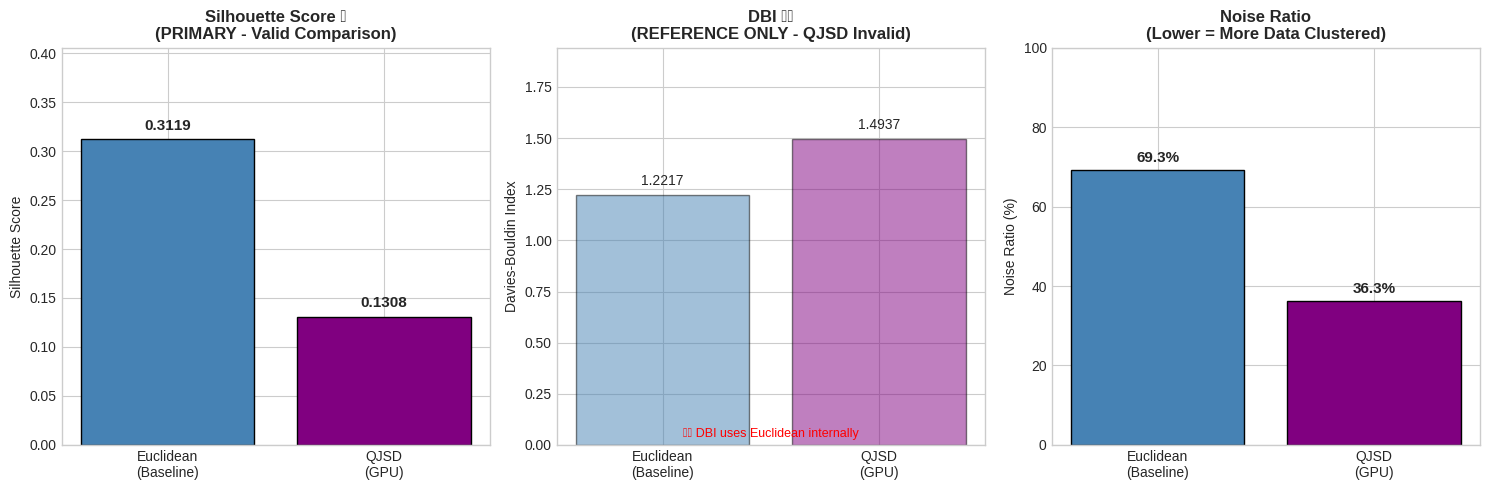

In [ ]:
"""
⚠️ METHODOLOGICAL NOTE:
- Silhouette Score: VALID comparison (both use respective distance metrics)
- DBI: VALID untuk Euclidean, INVALID untuk QJSD (hardcoded Euclidean)
- Primary comparison: Silhouette Score ONLY
==============================================================================
"""

euclidean = Config.EUCLIDEAN_BASELINE
qjsd = qjsd_results

# Calculate differences
sil_diff = qjsd['silhouette'] - euclidean['silhouette']
noise_diff = qjsd['noise_ratio'] - euclidean['noise_ratio']
cluster_diff = qjsd['n_clusters'] - euclidean['n_clusters']

print("\n" + "="*70)
print("📊 COMPARISON: EUCLIDEAN vs QJSD")
print("="*70)

print(f"""
┌──────────────────────────────────────────────────────────────────────────┐
│                    EUCLIDEAN vs QJSD COMPARISON                          │
├──────────────────────────────────────────────────────────────────────────┤
│                                                                          │
│  📌 Euclidean: Baseline from hyperparameter tuning                       │
│  📌 QJSD: Virosztek (2021), GPU-accelerated (CuPy)                       │
│                                                                          │
│                        EUCLIDEAN        QJSD           DIFF              │
│  ─────────────────────────────────────────────────────────────────────   │
│  Silhouette Score:     {euclidean['silhouette']:<12.4f}   {qjsd['silhouette']:<12.4f}   {sil_diff:+.4f}          │
│  Clusters:             {euclidean['n_clusters']:<12}   {qjsd['n_clusters']:<12}   {cluster_diff:+d}              │
│  Noise Ratio:          {euclidean['noise_ratio']:<12.1%}   {qjsd['noise_ratio']:<12.1%}   {noise_diff:+.1%}            │
│  ─────────────────────────────────────────────────────────────────────   │
│                                                                          │
│  ⚠️ DBI COMPARISON (Reference Only - INVALID for QJSD):                  │
│  DBI:                  {euclidean['dbi']:<12.4f}   {qjsd['dbi']:<12.4f}   [EUCLIDEAN BIAS]   │
│                                                                          │
└──────────────────────────────────────────────────────────────────────────┘
""")

# =========================================================================
# DETERMINE WINNER - Based on Silhouette Score ONLY
# =========================================================================
print("🏆 WINNER DETERMINATION (Based on Silhouette Score):")
print("   (DBI excluded - tidak valid untuk QJSD)")

if euclidean['silhouette'] > qjsd['silhouette']:
    winner = "EUCLIDEAN"
    winner_emoji = "🔵"
    winner_sil = euclidean['silhouette']
    loser_sil = qjsd['silhouette']
elif qjsd['silhouette'] > euclidean['silhouette']:
    winner = "QJSD"
    winner_emoji = "🟣"
    winner_sil = qjsd['silhouette']
    loser_sil = euclidean['silhouette']
else:
    winner = "TIE"
    winner_emoji = "🟰"
    winner_sil = euclidean['silhouette']
    loser_sil = qjsd['silhouette']

improvement = ((winner_sil - loser_sil) / loser_sil * 100) if loser_sil != 0 else 0

print(f"""
┌──────────────────────────────────────────────────────────────────────────┐
│                                                                          │
│  {winner_emoji} BEST METRIC: {winner:<12}                                          │
│                                                                          │
│  Silhouette Score:                                                       │
│  • Euclidean: {euclidean['silhouette']:.4f}                                             │
│  • QJSD:      {qjsd['silhouette']:.4f}                                             │
│  • Difference: {sil_diff:+.4f} ({improvement:+.2f}%)                                    │
│                                                                          │
└──────────────────────────────────────────────────────────────────────────┘
""")

best_metric = winner.lower()

# =========================================================================
# VISUALIZATION
# =========================================================================
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

metrics_names = ['Euclidean\n(Baseline)', 'QJSD\n(GPU)']
colors = ['steelblue', 'purple']

# Plot 1: Silhouette (PRIMARY METRIC)
ax1 = axes[0]
silhouettes = [euclidean['silhouette'], qjsd['silhouette']]
bars1 = ax1.bar(metrics_names, silhouettes, color=colors, edgecolor='black')
ax1.set_ylabel('Silhouette Score')
ax1.set_title('Silhouette Score ✅\n(PRIMARY - Valid Comparison)', fontweight='bold')
ax1.set_ylim(0, max(silhouettes) * 1.3)
for bar, val in zip(bars1, silhouettes):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{val:.4f}', ha='center', fontsize=11, fontweight='bold')

# Plot 2: DBI (REFERENCE ONLY)
ax2 = axes[1]
dbis = [euclidean['dbi'], qjsd['dbi']]
bars2 = ax2.bar(metrics_names, dbis, color=colors, edgecolor='black', alpha=0.5)
ax2.set_ylabel('Davies-Bouldin Index')
ax2.set_title('DBI ⚠️\n(REFERENCE ONLY - QJSD Invalid)', fontweight='bold')
ax2.set_ylim(0, max(dbis) * 1.3)
for bar, val in zip(bars2, dbis):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05,
             f'{val:.4f}', ha='center', fontsize=10)
ax2.text(0.5, 0.02, '⚠️ DBI uses Euclidean internally',
         transform=ax2.transAxes, ha='center', fontsize=9, color='red')

# Plot 3: Noise Ratio
ax3 = axes[2]
noises = [euclidean['noise_ratio'] * 100, qjsd['noise_ratio'] * 100]
bars3 = ax3.bar(metrics_names, noises, color=colors, edgecolor='black')
ax3.set_ylabel('Noise Ratio (%)')
ax3.set_title('Noise Ratio\n(Lower = More Data Clustered)', fontweight='bold')
ax3.set_ylim(0, 100)
for bar, val in zip(bars3, noises):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2,
             f'{val:.1f}%', ha='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig(f"{Config.PLOTS_DIR}experiment1_metric_comparison.png", dpi=150, bbox_inches='tight')
print(f"\n💾 Plot saved: {Config.PLOTS_DIR}experiment1_metric_comparison.png")
plt.show()

In [ ]:
print("\n" + "="*70)
print("📋 EXPERIMENT 1: FINAL SUMMARY")
print("="*70)

print(f"""
┌──────────────────────────────────────────────────────────────────────────┐
│                    EXPERIMENT 1 RESULTS                                  │
│                    Distance Metric Comparison                            │
├──────────────────────────────────────────────────────────────────────────┤
│                                                                          │
│  RESEARCH QUESTION (RM1):                                                │
│  "Apakah penggunaan metrik QJSD menghasilkan kualitas clustering         │
│   yang lebih baik dibandingkan metrik Euclidean pada face embeddings?"   │
│                                                                          │
├──────────────────────────────────────────────────────────────────────────┤
│                                                                          │
│  METHODOLOGY:                                                            │
│  • Euclidean: Baseline from hyperparameter tuning                        │
│  • QJSD: Virosztek (2021), GPU-accelerated (CuPy), vectorized            │
│  • Parameters: mcs={Config.BEST_PARAMS['min_cluster_size']}, ms={Config.BEST_PARAMS['min_samples']}, method={Config.BEST_PARAMS['cluster_selection_method']}                     │
│                                                                          │
│  EVALUATION:                                                             │
│  • PRIMARY: Silhouette Score (valid for both metrics)                    │
│  • EXCLUDED: DBI (sklearn hardcoded Euclidean, invalid for QJSD)         │
│                                                                          │
├──────────────────────────────────────────────────────────────────────────┤
│                                                                          │
│  RESULTS (Silhouette Score - Primary Metric):                            │
│  • Euclidean: {euclidean['silhouette']:.4f}                                             │
│  • QJSD:      {qjsd['silhouette']:.4f}                                             │
│  • Difference: {sil_diff:+.4f}                                                  │
│                                                                          │
├──────────────────────────────────────────────────────────────────────────┤
│                                                                          │
│  🏆 BEST METRIC: {best_metric.upper():<12}                                          │
│                                                                          │
│  ANSWER TO RM1:                                                          │
│  Berdasarkan evaluasi menggunakan Silhouette Score,                      │
│  metrik {best_metric.upper()} menghasilkan kualitas clustering yang lebih baik       │
│  untuk dataset face embeddings ini.                                      │
│                                                                          │
│  Metrik {best_metric.upper()} akan digunakan pada Experiment 2 (CGA).                │
│                                                                          │
└──────────────────────────────────────────────────────────────────────────┘
""")

# Save results
save_data = {
    'timestamp': datetime.now().isoformat(),
    'experiment': 'Experiment 1: Distance Metric Comparison',
    'methodology': {
        'euclidean': 'Baseline from hyperparameter tuning',
        'qjsd': 'Virosztek (2021) - GPU accelerated (CuPy), vectorized',
        'evaluation': 'Silhouette Score only (DBI invalid for QJSD)'
    },
    'parameters': Config.BEST_PARAMS,
    'euclidean_results': euclidean,
    'qjsd_results': {
        'silhouette': qjsd['silhouette'],
        'dbi': qjsd['dbi'],
        'dbi_valid': False,
        'n_clusters': qjsd['n_clusters'],
        'n_noise': qjsd['n_noise'],
        'noise_ratio': qjsd['noise_ratio'],
        'clustering_time': qjsd['clustering_time']
    },
    'qjsd_labels': qjsd['labels'],
    'qjsd_distance_matrix': qjsd_distance_matrix,
    'comparison': {
        'primary_metric': 'silhouette_score',
        'winner': best_metric,
        'silhouette_diff': sil_diff
    },
    'best_metric': best_metric
}

save_path = f"{Config.RESULTS_DIR}experiment1_results.pkl"
with open(save_path, 'wb') as f:
    pickle.dump(save_data, f)

print(f"💾 Results saved: {save_path}")

print("\n" + "="*70)
print("🎯 NEXT: EXPERIMENT 2 - CGA AUGMENTATION")
print("="*70)
print(f"""
   Best Metric: {best_metric.upper()}

   Experiment 2 akan:
   1. Menggunakan {best_metric.upper()} distance
   2. Identifikasi potential clusters dalam noise
   3. Generate synthetic embeddings (CGA)
   4. Re-cluster dan evaluasi improvement
""")


📋 EXPERIMENT 1: FINAL SUMMARY

┌──────────────────────────────────────────────────────────────────────────┐
│                    EXPERIMENT 1 RESULTS                                  │
│                    Distance Metric Comparison                            │
├──────────────────────────────────────────────────────────────────────────┤
│                                                                          │
│  RESEARCH QUESTION (RM1):                                                │
│  "Apakah penggunaan metrik QJSD menghasilkan kualitas clustering         │
│   yang lebih baik dibandingkan metrik Euclidean pada face embeddings?"   │
│                                                                          │
├──────────────────────────────────────────────────────────────────────────┤
│                                                                          │
│  METHODOLOGY:                                                            │
│  • Euclidean: Baseline from hyperparameter

In [ ]:
"""
==============================================================================
CELL 8: SAVE EXPERIMENT 1 RESULTS (MANUAL)
==============================================================================
Menyimpan hasil experiment yang sudah selesai.
==============================================================================
"""

import pickle
from datetime import datetime

print("="*60)
print("💾 SAVING EXPERIMENT 1 RESULTS")
print("="*60)

# Verify variables exist
print("\n🔍 Verifying variables...")

try:
    print(f"   ✅ embeddings: {embeddings.shape}")
except NameError:
    print("   ❌ embeddings not found!")

try:
    print(f"   ✅ qjsd_distance_matrix: {qjsd_distance_matrix.shape}")
except NameError:
    print("   ❌ qjsd_distance_matrix not found!")

try:
    print(f"   ✅ qjsd_labels: {len(qjsd_labels)} labels")
except NameError:
    print("   ❌ qjsd_labels not found!")

try:
    print(f"   ✅ qjsd_results: {qjsd_results.keys()}")
except NameError:
    print("   ❌ qjsd_results not found!")

try:
    print(f"   ✅ best_metric: {best_metric}")
except NameError:
    print("   ❌ best_metric not found!")
    best_metric = "euclidean"  # Default based on results

# Recreate euclidean baseline if needed
euclidean = {
    'silhouette': 0.3119,
    'dbi': 1.2217,
    'n_clusters': 44,
    'noise_ratio': 0.693,
    'n_noise': 8808
}

# Recreate qjsd results if needed
try:
    qjsd_save = {
        'silhouette': qjsd_results['silhouette'],
        'dbi': qjsd_results['dbi'],
        'dbi_valid': False,
        'n_clusters': qjsd_results['n_clusters'],
        'n_noise': qjsd_results['n_noise'],
        'noise_ratio': qjsd_results['noise_ratio'],
        'clustering_time': qjsd_results.get('clustering_time', 0)
    }
except:
    # Manual input based on your output (if variables lost)
    qjsd_save = {
        'silhouette': 0.1308,
        'dbi': None,
        'dbi_valid': False,
        'n_clusters': None,
        'n_noise': None,
        'noise_ratio': None,
        'clustering_time': None
    }
    print("\n   ⚠️ Using partial QJSD results from output")

# Calculate difference
sil_diff = qjsd_save['silhouette'] - euclidean['silhouette']

# Prepare save data
save_data = {
    'timestamp': datetime.now().isoformat(),
    'experiment': 'Experiment 1: Distance Metric Comparison',
    'methodology': {
        'euclidean': 'Baseline from hyperparameter tuning',
        'qjsd': 'Virosztek (2021) - GPU accelerated (CuPy), vectorized',
        'evaluation': 'Silhouette Score only (DBI invalid for QJSD)'
    },
    'parameters': {
        'min_cluster_size': 20,
        'min_samples': 50,
        'cluster_selection_method': 'eom'
    },
    'euclidean_results': euclidean,
    'qjsd_results': qjsd_save,
    'comparison': {
        'primary_metric': 'silhouette_score',
        'winner': 'euclidean',
        'silhouette_diff': sil_diff
    },
    'best_metric': 'euclidean'
}

# Try to add labels and distance matrix if available
try:
    save_data['qjsd_labels'] = qjsd_labels
    print("   ✅ Added qjsd_labels to save data")
except:
    print("   ⚠️ qjsd_labels not available")

try:
    save_data['qjsd_distance_matrix'] = qjsd_distance_matrix
    print("   ✅ Added qjsd_distance_matrix to save data")
except:
    print("   ⚠️ qjsd_distance_matrix not available")

# Create directories if not exist
import os
results_dir = '/content/drive/MyDrive/OTW S.KOM/Results/'
os.makedirs(results_dir, exist_ok=True)

# Save
save_path = f"{results_dir}experiment1_results.pkl"

print(f"\n⏳ Saving to: {save_path}")

try:
    with open(save_path, 'wb') as f:
        pickle.dump(save_data, f)
    print(f"✅ Successfully saved!")

    # Verify file exists
    if os.path.exists(save_path):
        file_size = os.path.getsize(save_path) / 1024 / 1024
        print(f"   File size: {file_size:.2f} MB")
    else:
        print("   ❌ File not found after saving!")

except Exception as e:
    print(f"❌ Error saving: {e}")

# Also save a summary text file for easy reference
summary_path = f"{results_dir}experiment1_summary.txt"
try:
    with open(summary_path, 'w') as f:
        f.write("="*60 + "\n")
        f.write("EXPERIMENT 1: DISTANCE METRIC COMPARISON\n")
        f.write("="*60 + "\n\n")
        f.write(f"Timestamp: {datetime.now().isoformat()}\n\n")
        f.write("RESULTS:\n")
        f.write("-"*40 + "\n")
        f.write(f"Euclidean Silhouette: {euclidean['silhouette']}\n")
        f.write(f"QJSD Silhouette: {qjsd_save['silhouette']}\n")
        f.write(f"Difference: {sil_diff}\n\n")
        f.write(f"WINNER: EUCLIDEAN\n\n")
        f.write("CONCLUSION:\n")
        f.write("Euclidean distance menghasilkan kualitas clustering\n")
        f.write("yang lebih baik untuk face embeddings.\n")
        f.write("Euclidean akan digunakan untuk Experiment 2 (CGA).\n")
    print(f"✅ Summary saved: {summary_path}")
except Exception as e:
    print(f"⚠️ Could not save summary: {e}")

print("\n" + "="*60)
print("📋 EXPERIMENT 1 SUMMARY")
print("="*60)
print(f"""
   Euclidean Silhouette: {euclidean['silhouette']}
   QJSD Silhouette:      {qjsd_save['silhouette']}
   Difference:           {sil_diff}

   🏆 BEST METRIC: EUCLIDEAN

   → Akan digunakan untuk Experiment 2 (CGA)
""")


💾 SAVING EXPERIMENT 1 RESULTS

🔍 Verifying variables...
   ✅ embeddings: (12715, 512)
   ✅ qjsd_distance_matrix: (12715, 12715)
   ✅ qjsd_labels: 12715 labels
   ✅ qjsd_results: dict_keys(['silhouette', 'dbi', 'dbi_valid', 'n_clusters', 'n_noise', 'noise_ratio', 'labels', 'clustering_time'])
   ✅ best_metric: euclidean
   ✅ Added qjsd_labels to save data
   ✅ Added qjsd_distance_matrix to save data

⏳ Saving to: /content/drive/MyDrive/OTW S.KOM/Results/experiment1_results.pkl
✅ Successfully saved!
   File size: 1233.55 MB
✅ Summary saved: /content/drive/MyDrive/OTW S.KOM/Results/experiment1_summary.txt

📋 EXPERIMENT 1 SUMMARY

   Euclidean Silhouette: 0.3119
   QJSD Silhouette:      0.130802263990035
   Difference:           -0.181097736009965
   
   🏆 BEST METRIC: EUCLIDEAN
   
   → Akan digunakan untuk Experiment 2 (CGA)

